# Unet Model for Tree Segmentation
The purpose of this project is to train a Unet segmentation model in Pytorch that will identify individual standing trees on satellite images. 

In [0]:
# Load Packages
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
from sklearn.metrics import f1_score
from PIL import Image
from io import BytesIO
from torch.utils.data import Dataset
from sklearn.cluster import KMeans
import skimage.segmentation as ski
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as opt
import matplotlib.pyplot as plt
import subprocess
from sklearn.model_selection import train_test_split
import sys

### Dataset
The dataset consists of just 168 satellite images of trees. This number alone is not significant to train a robust model. Therefore, I used various data augmentation techniques, such as rotation, flips, and color jitter. I argue that all these augmentations are relevant here because a satellite can capture the image of the Earth from different angles and with different illumination levels. 
I also defined a `NumPyDataset` class that turns standard numpy arrays into a format suitable for PyTorch as well as a `create_loaders` function that returns train and validation loaders that can be used in training. 

In [4]:
# Load data
images = np.load('images.npy')
labels = np.load('gts.npy')

# Check dimensions
images[0].shape, labels[0].shape

((256, 256, 3), (256, 256))

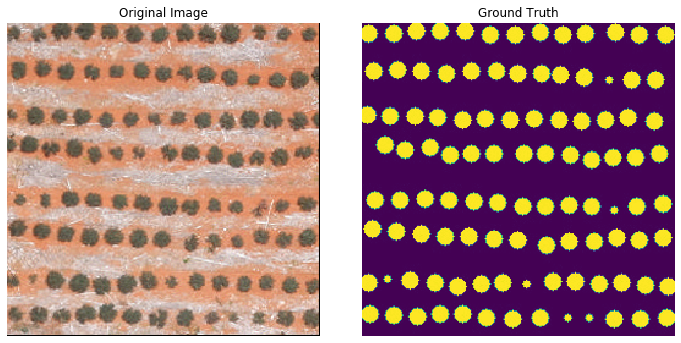

In [5]:
# Plot examples
f, ax = plt.subplots(nrows=1,
                     ncols=2,
                     figsize=(10,7))
plt.tight_layout()
ax[0].imshow(images[0])
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(labels[0])
ax[1].set_title('Ground Truth')
plt.axis('off')
plt.show()

In [0]:
class NumPyDataset(Dataset):
    """ Creates a Pytorch Dataset out of Numpy arrays. """
    def __init__(self, X, y, transform_img=None, transform_mask=None):
        """ Initialize a NumPy Dataset instance
        Parameters
        ----------
        X : np.array
            Original images that we want to segment
        y: np.array
            Ground truth values
        transorm_img (opt): PyTorch oblect
            A list of transformations we want to apply
            to X
        transorm_mask (opt): PyTorch oblect
            A list of transformations we want to apply
            to y
        """
        self.X = X
        self.y = y
        self.transform_img = transform_img
        self.transform_mask = transform_mask
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        # Turn arrays into images
        X_sample = Image.fromarray((self.X[index] * 255).astype(np.uint8))
        y_sample = Image.fromarray((self.y[index]).astype(np.uint8))
        # Transform images if necessary
        X_sample = self.transform_img(X_sample)
        y_sample = self.transform_mask(y_sample)
        return X_sample, y_sample

def transform(n):
    ''' Create random transformations in PyTorch.
      Parameters
      ----------
      n : int
          Number of times we want to apply transformations.
      
      Returns
      -------     
      trans_img, trans_mask: PyTorch Object
          A set of random transformations that can be
          applied to images and masks
    '''
    transformations_img, transformations_mask = [], []
    # Identify ranges of possible parameter values
    brightness = np.linspace(0, 0.2, 10)
    contrast = np.linspace(0, 0.2, 10)
    saturation = np.linspace(0, 0.2, 10)
    hue = np.linspace(0, 0.2, 10)
    hflip = np.array([0, 1])
    vflip = np.array([0, 1])
    rotate = np.linspace(0, 360, 36)
    
    for _ in range(n):
        # Select specific parameter values for images and GTs
        b = np.random.choice(brightness)
        c = np.random.choice(contrast)
        s = np.random.choice(saturation)
        hu = np.random.choice(hue)
        h = np.random.choice(hflip)
        v = np.random.choice(vflip)
        r = np.random.choice(rotate)
        # Transform for images
        transform_img = transforms.Compose([
            transforms.ColorJitter(brightness=b, contrast=c, saturation=s, hue=hu), 
            transforms.RandomHorizontalFlip(p=h),
            transforms.RandomVerticalFlip(p=v),
            transforms.RandomRotation(degrees=(r,r)),
            transforms.ToTensor(),
        ])
        transformations_img.append(transform_img)
        
        # Transform for GTs
        transform_mask = transforms.Compose([
            transforms.RandomHorizontalFlip(p=h),
            transforms.RandomVerticalFlip(p=v),
            transforms.RandomRotation(degrees=(r,r)),
            transforms.ToTensor(),
        ])
        transformations_mask.append(transform_mask)
    
    return transformations_img, transformations_mask


def create_loaders(img, labels, n_augmented):
    '''Create train and validation loaders.
    '''
    # Create transfor objects
    transformations_img, transformations_mask = transform(n_augmented)
    org_train_img, org_val_img, org_train_labels, org_val_labels = train_test_split(img,
                                    labels,
                                    test_size=train_val_split) 
    org_train = NumPyDataset(org_train_img, 
                             org_train_labels, 
                             transform_img=transforms.ToTensor(), 
                             transform_mask=transforms.ToTensor()) 
    augmented_train = [NumPyDataset(org_train_img, 
                                    org_train_labels, 
                                    transform_img=trans_img, 
                                    transform_mask=trans_mask)\
                     for trans_img, trans_mask in zip(transformations_img, transformations_mask)]
    augmented_train.append(org_train)
    # Combine augmented and original images
    train_dataset = utils.ConcatDataset(augmented_train)
    org_val = NumPyDataset(org_val_img, org_val_labels, transform_img=transforms.ToTensor(), transform_mask=transforms.ToTensor()) 
    # Create loaders
    train_loader = utils.DataLoader(train_dataset, batch_size=batch_size)
    validation_loader = utils.DataLoader(org_val, batch_size=batch_size)
    return train_loader, validation_loader

In [0]:
# Percentage of training set to use as validation
train_val_split = 0.2
# Number of augmented datasets
n_augmented = 10
# Number of subprocesses to use for data loading
num_workers = 0
# Nunber of samples per batch
batch_size = 4
# Number of epochs
num_epoch = 20
# Learning rate
lr = 0.001
# Momentum
momentum = 0.9

# Create final datasets with 10X augmentation
trans_img, trans_mask = transform(n_augmented)
train_loader, validation_loader = create_loaders(images, labels, n_augmented)

### Model Specification
Traditional CNN models use convolutions to convert images into vectors that can be further used for classification tasks. Image segmentation is a more complicated problem because we not only need to convert the feature map into a vector but also reconstruct an image from this vector. The Unet is a state-of-the-art architecture that tries to tackle this problem. The main idea behind Unet is that since we learn the feature mapping of the image while converting it to the vector, it makes sense to use the same mapping to convert the vector back to the image.

The architecture consists of two main parts: contraction and expansion. The contraction part consists of several convolutional layers that are defined in the `ConvLayer` class. Each convolution is followed by a regularization factor, `Dropout`, and `BatchNorm`  to improve the speed and robustness of the training, as well as the activation function - `LeakyReLU`. In the contractor part, I also perform MaxPooling for dimensionality reduction. Apart from performing upsampling, the expansion part of the network uses skip connections by concatenating the output of the expansion layers with the feature maps from the contraction model at the same level. Skip connections help traverse information faster and make sure less information is lost in the training loop. 

In [0]:
class ConvLayer(nn.Module):
  ''' Base convolutional layer class based on the PyTorch module.'''
  def __init__(self, n_in, n_out): 
    '''Initialize a ConvLayer.
      Parameters
      ----------
      n_in : int
          Input dimension
      n_out: int
    '''
    super(ConvLayer, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(n_in, n_out, 3, padding=1),
        # Add Dropout
        nn.Dropout2d(p=0.1),
        # Add batch normalization
        nn.BatchNorm2d(n_out),
        # Add activation function
        nn.LeakyReLU(inplace=True))

  def forward(self, x):
      x = self.layer(x)
      return x
    
class Up(nn.Module): 
  ''' 
  The expansion part of the notebook. Performs deconvolutions 
  and skip connections.
  '''
  def __init__(self, n_in, n_out): 
      super(Up, self).__init__()
      self.layer1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.layer2 = ConvLayer(n_in, n_out)

  def forward(self, x1, x2):
      # Actual input
      x1 = self.layer1(x1)
      # x2 is the skip connection copy from the contractor
      y_dim_diff = x2.size()[3] - x1.size()[3]
      x_dim_diff = x2.size()[2] - x1.size()[2]
      # Pad actual input with the difference to enable concatenation
      x1 = F.pad(x1, (x_dim_diff // 2, x_dim_diff - x_dim_diff//2,
                      y_dim_diff // 2, y_dim_diff - y_dim_diff//2))
      x = torch.cat([x2, x1], dim=1)
      # Convolve the layer back to the required size
      x = self.layer2(x)
      return x
    

class Down(nn.Module): 
  ''' 
  The contractor of the notebook. Performs convolutions 
  and MaxPooling.
  '''
  def __init__(self, n_in, n_out): 
      super(Down, self).__init__()
      self.layer = nn.Sequential(
          nn.MaxPool2d(kernel_size=2, stride=2), 
          ConvLayer(n_in, n_out))
      
  def forward(self, x):
      x = self.layer(x)
      return x
    

class UNet(nn.Module): 
  ''' 
  Actual Unet architecture that combines
  all parts together.
  '''
  def __init__(self, n_in): 
    '''Define all layers. '''
    super(UNet, self).__init__()
    self.conv_in = ConvLayer(n_in, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    self.down4 = Down(512, 1024)
    self.up1 = Up(1024+512, 512)
    self.up2 = Up(512+256, 256)
    self.up3 = Up(256+128, 128)
    self.up4 = Up(128+64, 64)
    self.conv_out = nn.Conv2d(64, 1, 1)

  def forward(self, x):
    '''The forward path of the network. '''
    # Contraction
    x1 = self.conv_in(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    # Expansion
    x4_up = self.up1(x5, x4)
    x3_up = self.up2(x4_up, x3)
    x2_up = self.up3(x3_up, x2)
    x_up = self.up4(x2_up, x1)
    x_up = self.conv_out(x_up)

    return torch.sigmoid(x_up)

### Loss functions

Even though binary cross-entropy, in combination with the softmax, is a popular choice for many computer vision tasks, I will experiment with another type of loss, which is generally considered to be useful for segmentation problems -- dice loss. In its essence, the dice loss is the size of the overlap of the two segmentations divided by the total size of the two objects, the same as the F1 score. Sudre et al. (2017) state that a weighted combination of the binary cross-entropy and dice loss has the best performance. I will implement it for my model.

In [0]:
def loss_func(pred, label):
    ''' Binary Cross-Entropy (BCE). '''
    func = nn.BCELoss()
    bce_loss = func(pred, label)
    return bce_loss 


def dice_loss(pred, target, smooth = 1.):
    ''' Implement dice loss. '''
    # contiguous() makes a copy of tensor so the order of elements would 
    # be same as if tensor of same shape created from scratch.
    pred = pred.contiguous()
    target = target.unsqueeze(1)
    target = target.contiguous()        

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


def weighted_dice_loss(pred, target,bce_weight=0.08):
    ''' Implement a weighted average of 2 losses. '''
    bce = bce_loss(pred, target)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss

In [0]:
def train_Unet(data_generator_train, 
               data_val_gen, model, 
               loss, optimizer, 
               n_epochs = num_epoch):
  ''' Train Unet using the model architecture and dataset specified above.'''
  best_val_loss = torch.Tensor([10**6])
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.cuda()
  optimizer = optimizer
  loss_func = loss
  # Record performance
  record_loss_train = []
  record_loss_val = []
  for epoch in range(n_epochs):
      print("n_epochs")
      for index, data in enumerate(data_generator_train): 
          imgs, labels = data
          imgs, labels = imgs.cuda(), labels.cuda()
          model.train()
          optimizer.zero_grad()
          output = model(imgs)
          loss_train = loss(output, labels)
          loss_train.backward()
          optimizer.step()
      
          for _, data in enumerate(data_val_gen):
              imgs_val, labels_val = data
              imgs_val, labels_val = imgs_val.cuda(), labels_val.cuda()
          model.eval()
          with torch.no_grad():
              output = model(imgs_val)
              loss_validation = loss(output, labels_val)
          # Print our results after 100 steps
          if index % 100 == 0:
              print('Epoch %d, iteration %5d -- Training loss: %.3f' % (epoch + 1, index+1, loss_train))
              record_loss_train.append(loss_train)
              print('Epoch %d, iteration %5d -- Validation loss: %.3f' % (epoch + 1, index+1, loss_validation))
              record_loss_val.append(loss_validation)
      if loss_validation.cpu().numpy() < best_val_loss.cpu().numpy():
          print('Validation loss improved, saving model...')
          best_val_loss = loss_validation

  print('Training completed')            
  return record_loss_train, record_loss_val

Let's train the model:

In [ ]:
model = UNet(3)
bce_loss = nn.BCELoss()
loss = weighted_dice_loss
# Use Stochastic Gradient Descent
optimizer = opt.SGD(model.parameters(), lr=lr, momentum=momentum) 
torch.cuda.empty_cache()
tloss, vloss = train_Unet(train_loader, validation_loader, model, loss, optimizer)

### Interpretation

The graph below illustrates the change in training and validation loss. Even though the validation loss is a bit worse than the training loss, there are no indicators of overfitting because they seem to decrease at a similar rate. The training loss curve is relatively unstable, which is likely due to the small sample size. It also seems like it follows a repetitive pattern, but I'm not sure what causes it. Overall, the model seems to learn well at the beginning of the training and show only a small improvement in later epochs. It's highly likely that it cannot generalize very well. 

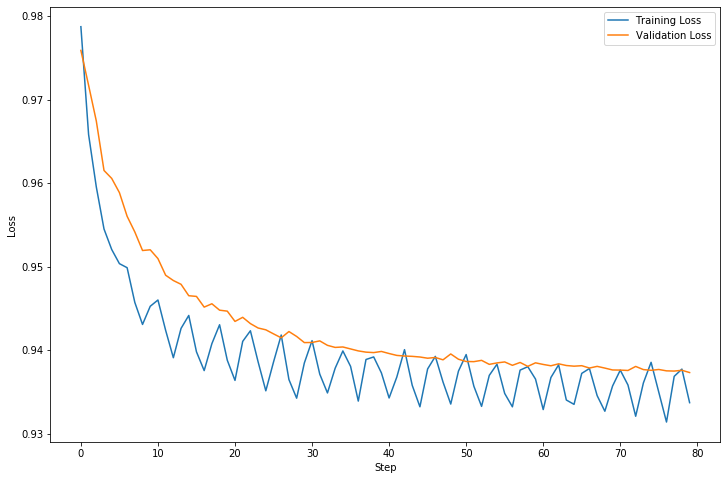

In [44]:
plt.figure(figsize=(12,8))
plt.plot(range(len(tloss)), tloss, label="Training Loss")
plt.plot(range(len(vloss)), vloss, label="Validation Loss")
plt.legend()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

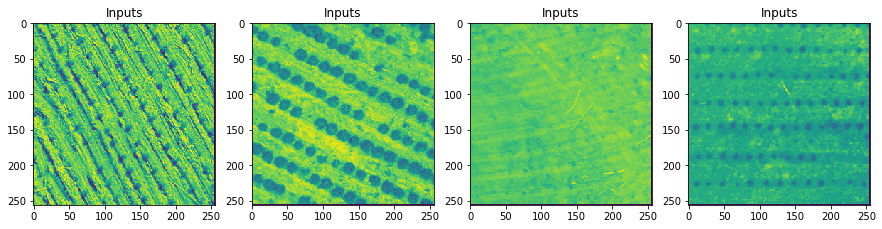

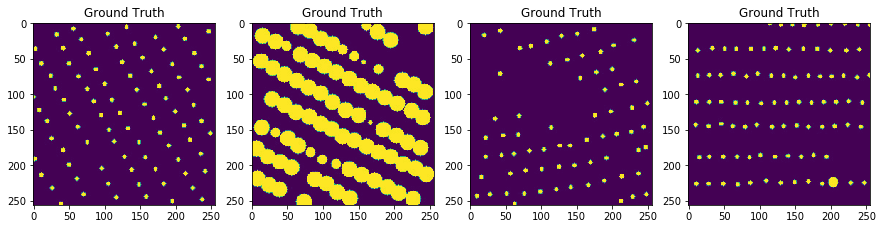

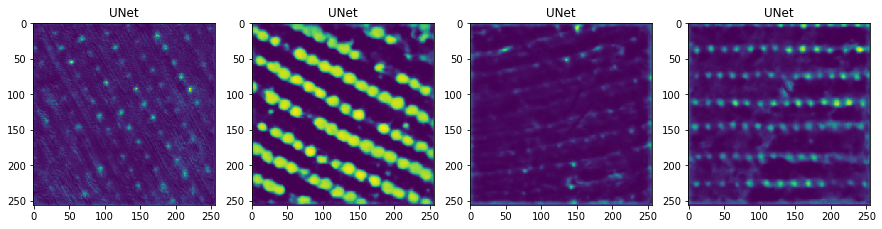

In [45]:
'''
PLOT NETWORK PREDICTIONS
'''

dataiter = iter(validation_loader)
images, labels = dataiter.next()
images[0].shape

plt.figure(figsize=(15,20))
for _ in range(4): 
    plt.subplot(1, 4, _+1)
    plt.imshow(images[_][0].numpy())
    plt.title('Inputs')
plt.show()

plt.figure(figsize=(15,20))
for _ in range(4): 
    plt.subplot(1, 4, _+1)
    plt.imshow(labels[_][0].numpy())
    plt.title('Ground Truth')
plt.show()

images = images.cuda()
model.cuda()
preds = model(images)


plt.figure(figsize=(15,20))
for _ in range(4): 
    plt.subplot(1, 4, _+1)
    plt.imshow(preds[_][0].cpu().detach().numpy())
    plt.title('UNet')
plt.show()
l = [labels, preds]

### Postprocessing
The output of the network is continuous values from 0 to 1. The image above illustrates that the contours of the trees are very blurry. In this section, I will try to tackle this problem by visually examining different thresholds to create binary masks. 

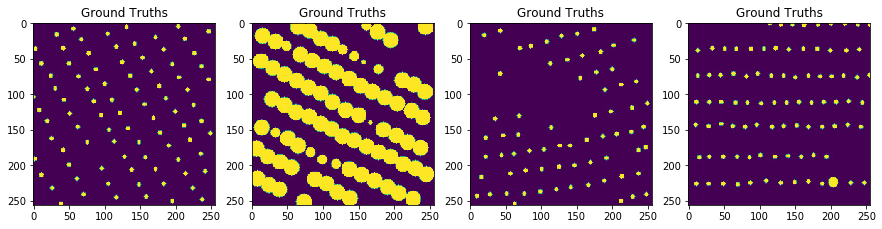

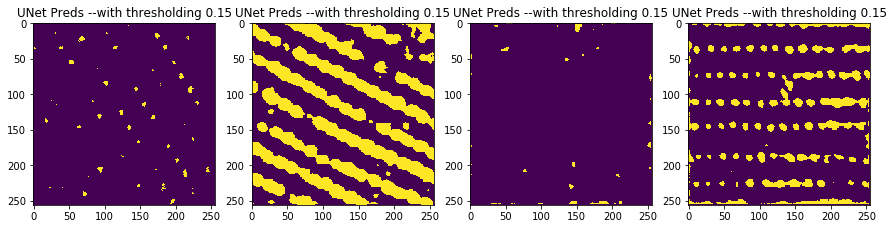

In [53]:
def thresholding(threshold, loader, model):
    ''' Threshold network outputs for clearer predicitons. '''
    dataiter = iter(loader)
    images, labels = dataiter.next()
    images = images.cuda()
    model.cuda()
    preds = model(images)
    preds_np = preds.cpu().detach().numpy()
    preds_np[preds_np >= threshold] = 1
    preds_np[preds_np < threshold] = 0
  
    plt.figure(figsize=(15,20))
    for _ in range(4): 
        plt.subplot(1, 4, _+1)
        plt.imshow(labels[_][0].numpy())
        plt.title('Ground Truths')
    plt.show()

    plt.figure(figsize=(15,20))
    for _ in range(4): 
        plt.subplot(1, 4, _+1)
        plt.imshow(preds_np[_][0])
        plt.title('UNet Preds --with thresholding {}'.format(threshold))
    plt.show()
thresholding(0.15, validation_loader, model)
    

The output above illustrates that the optimal value of the threshold depends on the average size of the tree. Bigger trees require a higher threshold to ensure they still look like individual trees, while small trees are at risk of disappearing in case the threshold is too high. 

### Resources

1. Sudre, C. H., Li, W., Vercauteren, T., Ourselin, S. and Jorge Cardoso, M.
Sudre, C., Li, W., Vercauteren, T., Ourselin, S., & Jorge Cardoso, M. (2017). Generalised Dice Overlap as a Deep Learning Loss Function for Highly Unbalanced Segmentations. Deep Learning In Medical Image Analysis And Multimodal Learning For Clinical Decision Support, 240-248. doi:10.1007/978-3-319-67558-9_28

2. Understanding Semantic Segmentation with UNET. (2019). Medium. Retrieved 14 November 2019, from https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b472

3. usuyama/pytorch-unet. (2019). GitHub. Retrieved 14 November 2019, from https://github.com/usuyama/pytorch-unet

